<a href="https://colab.research.google.com/github/limshaocong/analyticsEdge/blob/main/Copy_of_FAANG_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preliminaries**

In [85]:
suppressMessages(library(tidyverse)) # generic must have package
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2)) # plotting package
suppressMessages(library(lubridate)) # easy comprehension of dates from string to correct datetime format
suppressMessages(library(data.table))
suppressMessages(library(purrr)) # reduce
if("patchwork" %in% rownames(installed.packages()) == FALSE) {install.packages("patchwork")}
suppressMessages(library(patchwork))
if("caret" %in% rownames(installed.packages()) == FALSE) {install.packages("caret")}
suppressMessages(library(caret))

options(repr.plot.width = 10,
        repr.plot.height = 9,
        repr.plot.pointsize = 20)

Import data and check for any NA within the file

In [5]:
path = "https://raw.githubusercontent.com/limshaocong/analyticsEdge/main/Datasets/FAANG/altdata.csv"
df = read.csv(path) %>% mutate(date = mdy(date))

if (dim(df)[1] == dim(na.omit(df))[1]) {
  print("No missing data.")
} else {
  print("Missing data")
}

[1] "No missing data."


# **Exploratory Analysis**

Overview of Data

In [ ]:
head(df, 5)

,ticker,date,low,high,close,open,vol,newssentiment,newsmentions,twtrmentions,twtrsentiment,wsbmentions,wsbsentiment,pricetarget,voltarget
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,FB,2019-01-02,128.56,137.51,135.68,128.99,28142593,50,2,606,0.11716172,20,0.1814700,131.74,22716248
2,FB,2019-01-03,131.12,137.17,131.74,134.69,22716248,50,0,521,0.03071017,14,-0.1376714,137.95,29000732
3,FB,2019-01-04,133.75,138.00,137.95,134.01,29000732,50,0,431,0.05800464,10,-0.0623300,138.05,20088916
4,FB,2019-01-07,135.91,138.87,138.05,137.56,20088916,50,0,415,0.20240964,6,-0.2222167,142.53,26252863
5,FB,2019-01-08,139.54,143.14,142.53,139.89,26252863,63,2,569,0.26889279,6,0.3528667,144.23,22203279


504 trading days worth of training data from 2019 to 2020

In [ ]:
df %>%
  group_by(ticker) %>%
  summarise(n())

ticker,n()
<chr>,<int>
AAPL,504
AMZN,504
FB,504
GOOGL,504
NFLX,504


Plotting sentiment and changes in closing price

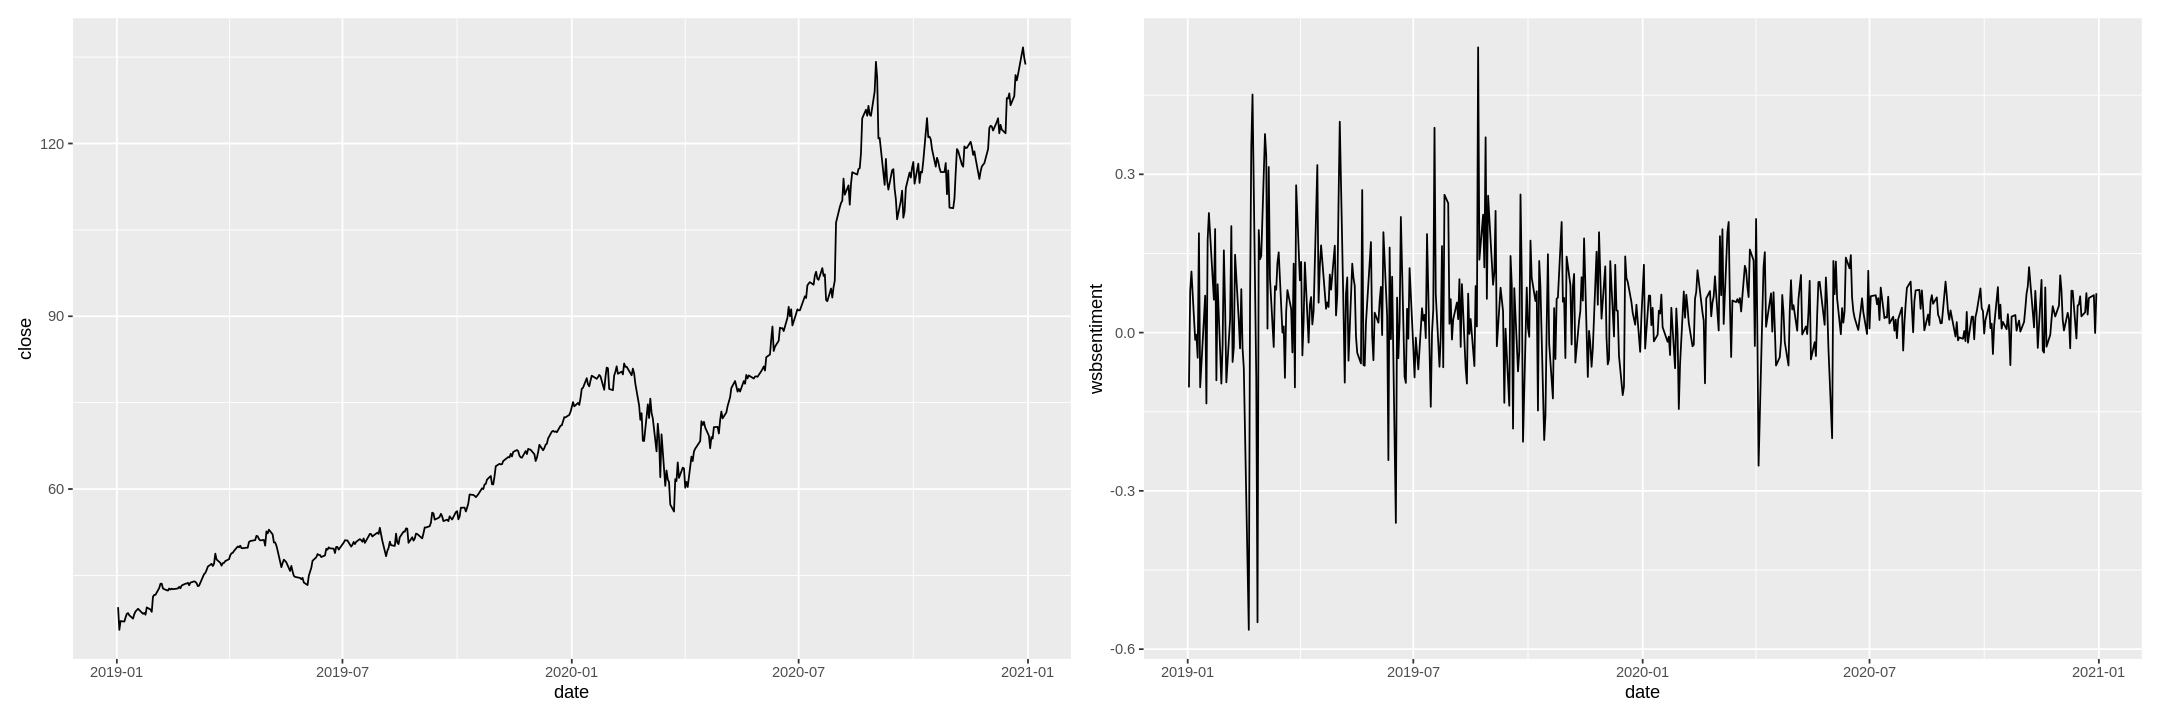

In [ ]:
p1 = df %>%
      filter(ticker == "AAPL") %>%
      ggplot() +
      geom_line(aes(x = date, y = close)) 

p2 = df %>%
      filter(ticker == "AAPL") %>%
      ggplot(aes(x = date)) +
      geom_line(aes(y = wsbsentiment)) 

p1
p2

# **Data Preparation**

Train-test split

In [8]:
split = as.Date("2020-06-30")

# Train-test split
train = df %>% filter(date < split)
test = df %>% filter(date >= split)

train_days = dim(train)[1]/5
test_days = dim(test)[1]/5

train_prop = train_days / (train_days + test_days)

paste0("Training data proportion: ", round(train_prop * 100, 1), "%. Total training days = ", train_days)

[1] "Training data proportion: 74.6%. Total training days = 376"

Train-validate Split - as normal k-fold CV does not work on time series, an expanding window approach is used (see Section 4.3 of https://topepo.github.io/caret/data-splitting.html#time). With these parameters, CV-error will be run on 5 different validation sets.

In [34]:
index = 1:train_days
slices = createTimeSlices(index, initialWindow = 130, horizon = 30, fixedWindow = FALSE, skip = 40)

trainslices = slices[[1]] # specific slices callable by df[trainslices[[i]],]
testslices = slices[[2]]

lapply(slices, length)

$train
[1] 6

$test
[1] 6

# **Model Building**

In [91]:
suppressMessages(library(rpart.plot))
if("Metrics" %in% rownames(installed.packages()) == FALSE) {install.packages("Metrics")}
suppressMessages(library(Metrics))
if("glm2" %in% rownames(installed.packages()) == FALSE) {install.packages("glm2")}
suppressMessages(library(glm2))

In [75]:
cart <- function() {
  
  train_control = trainControl(method = "timeslice",
                            initialWindow = 130,
                            horizon = 30,
                            fixedWindow = FALSE,
                            skip = 40)

  cp_values = data.frame(.cp = seq(0, 0.005, by = 0.0001))

  model = train(x = trainX,
                y = trainY,
                method = "rpart",
                trControl = train_control,
                tuneGrid = cp_values)

}

In [87]:
tick = "AAPL"

trainX = train %>% filter(ticker == tick) %>% select(c(3:13))
trainY = train %>% filter(ticker == tick) %>% select(c(14)) %>% pull()

testX = test %>% filter(ticker == tick) %>% select(c(3:13))
testY = test %>% filter(ticker == tick) %>% select(c(14)) %>% pull()

mod = cart()

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


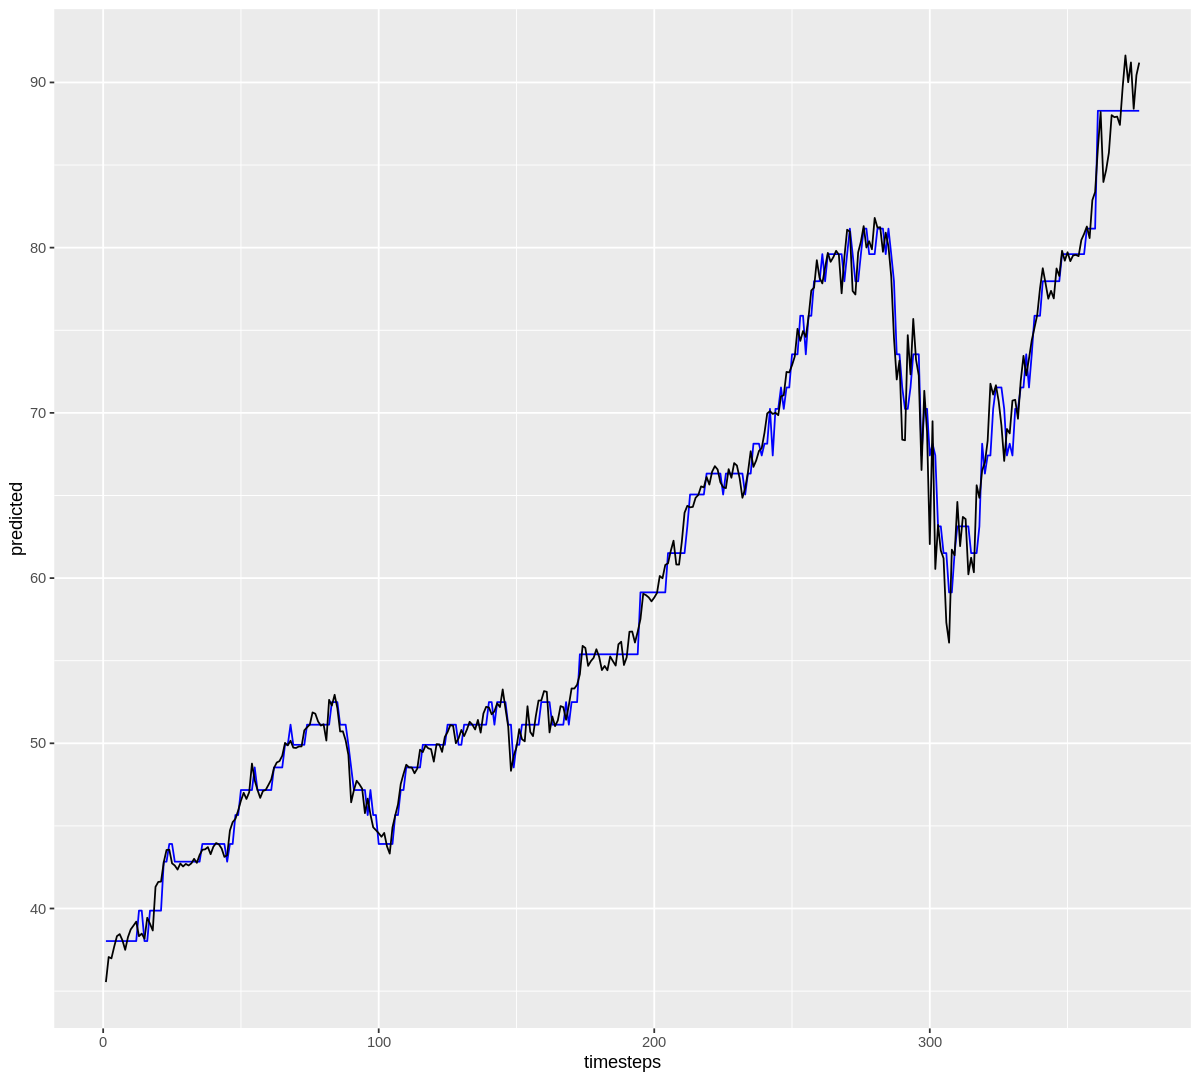

In [88]:
train_pred = predict(mod$finalModel, newdata = trainX)

tree_df = data.frame(timesteps = seq(1, train_days), predicted = train_pred, actual = trainY)

ggplot(data = tree_df, (aes(x = timesteps))) +
  geom_line(aes(y = predicted), color = "blue") +
  geom_line(aes(y = actual), color = "black")